# Table of Contents
 <p><div class="lev1"><a href="#Introduction"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2"><a href="#Collected-data"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Collected data</a></div><div class="lev2"><a href="#Collected-data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collected data</a></div><div class="lev2"><a href="#Latency"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Latency</a></div>

In [57]:
# button to toggle code
HTML('''<script>
code_show=true; 
function code_toggle() {
 document.title = 'Variance analysis';
 code_show = !code_show
 var divs = document.getElementsByClassName('input');
 var divs = document.getElementsByClassName('input');
 if (code_show){
   for (var i in divs) {
     if (typeof divs[i] != 'undefined') {
       divs[i].style.display = 'block';
     } 
   }
 } else {
   for (var i in divs) {
     if (typeof divs[i] != 'undefined') {
       divs[i].style.display = 'none';
     } 
   }
 }
} 

document.addEventListener("DOMContentLoaded", function(event) { 
  code_toggle()
});
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Introduction

The objective of this analysis is to study the distribution of network jitter in Tor entry guards. Some nodes might have a significantly large jitter than the average. We believe that in those cases, website fingerprinting may have lower effectiveness than in the entry guards with low jitter. The rationale is that even if the entry to guard TCP connection is independent of the website, the interaction between the page structure (HTTP request/response pattern) and the jitter, may make the fingerprint less reliable than in low-jitter guards.

In [58]:
%matplotlib inline
from os import listdir
from os.path import join, dirname, realpath, isdir, getmtime, splitext
from glob import glob

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell

# Notebook config
InteractiveShell.ast_node_interactivity = "all"

# directories
BASE_DIR = dirname(realpath("__file__"))
RESULTS_DIR = join(BASE_DIR, 'results')
LATEST_FILE = max([join(RESULTS_DIR, d) for d in listdir(RESULTS_DIR)], key=getmtime)
LATEST_DATA = '%s.csv' % splitext(LATEST_FILE)[0]

## Collected data


For our data collection, we make a TCP connection to the guard's OR port and record all the traffic that is generated. In total, we have collected:

In [59]:
# load data
data = pd.read_csv(join(LATEST_DATA))

num_samples = len(data)
print "- Total num samples:", num_samples

guards = data.groupby(['guard_fp'])['guard_fp'].count()
num_guards = len(guards)
print "- Found data for", num_guards, "entry guards"

avg_num_samples_per_guard = guards.mean()
print "- An average of", int(avg_num_samples_per_guard), "samples for each entry guard."

- Total num samples: 13
- Found data for 13 entry guards
- An average of 1 samples for each entry guard.


This is how the dataset looks like:

In [60]:
# load data in a dataframe
data.head()

,sample_id,guard_fp,latency
0,2194000,001524DD403D729F08F7,0.074747
1,2194000,00161E152FCF43380176,0.082679
2,2194001,00459AF0E9DED00E54A4,0.139132
3,2194001,0063D0DE32C80691A0AC,0.208920
4,2194000,006C0B92328C89043ECC,0.075512


## Latency

From the traffic traces collected for the TCP connections to the guards, we extract the first SYN+ACK packet (if any) and its corresponding SYN packet. Next, we substract the SYN timestamp to the SYN+ACK timestamp to obtain a measurement of the latency to a guard.

We extract some basic statistics about the latencies:

In [61]:
data['latency'].describe()

count    13.000000
mean      0.105752
std       0.052276
min       0.033181
25%       0.075512
50%       0.093991
75%       0.131871
max       0.208920
Name: latency, dtype: float64

We plot the histogram of latencies:

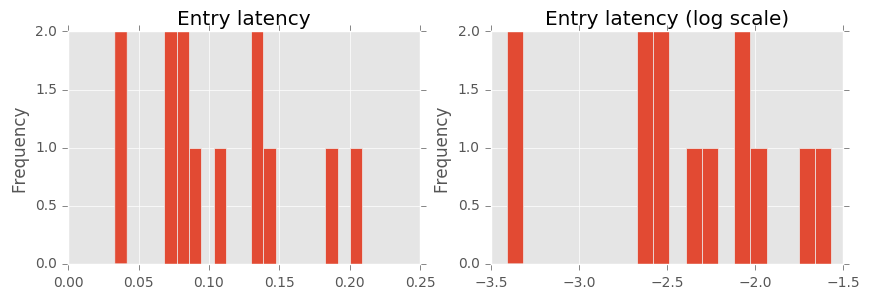

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
data['latency'].plot(kind='hist', bins=20, ax=ax1, figsize=(10, 3), title="Entry latency")
data['latency'].apply(np.log).plot(kind='hist', bins=20, ax=ax2, figsize=(10, 3), title="Entry latency (log scale)")

## Jitter

We measure jitter of a node as the variance of the node's latency. We can calculate the variance because we take several samples for each node.

In [63]:
def jitter(latencies):
    """Compute jitter from latency data."""
    return latencies.groupby(['guard_fp'])['latency'].std()

jitter(data).plot(kind='hist', bins=20, ax=ax1, figsize=(10, 3), title="Entry jitter")